In [1]:
# Read data and aggregate into monthly sale_cnt

import pandas as pd

train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
# columns: date, date_block_num, shop_id, item_id, item_price, item_cnt_day
train_monthly_df = train_df.groupby(['date_block_num','shop_id','item_id']).agg(item_cnt_month=('item_cnt_day','sum')).reset_index()
train_monthly_df['shop_item'] = train_monthly_df['shop_id'].astype('string') + '-' + train_monthly_df['item_id'].astype('string')
shop_item_list = pd.unique(train_monthly_df['shop_item'])
print("cnt of shop_item:",len(shop_item_list))
train_monthly_df

cnt of shop_item: 424124


,date_block_num,shop_id,item_id,item_cnt_month,shop_item
0,0,0,32,6.0,0-32
1,0,0,33,3.0,0-33
2,0,0,35,1.0,0-35
3,0,0,43,1.0,0-43
4,0,0,51,2.0,0-51
...,...,...,...,...,...
1609119,33,59,22087,6.0,59-22087
1609120,33,59,22088,2.0,59-22088
1609121,33,59,22091,1.0,59-22091
1609122,33,59,22100,1.0,59-22100


In [2]:
# get the sequence of each shop_item

import numpy as np

data_seq_dict = {}
for shop_item in shop_item_list:
    data_seq_dict[shop_item] = [0.0 for i in range(0,34)]
for _, row in train_monthly_df.iterrows():
    data_seq_dict[row['shop_item']][int(row['date_block_num'])] = row['item_cnt_month']

data_seq_array = np.array(list(data_seq_dict.values()))
print(data_seq_array)
print(data_seq_array.shape)

[[ 6. 10.  0. ...  0.  0.  0.]
 [ 3.  3.  0. ...  0.  0.  0.]
 [ 1. 14.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  1.]
 [ 0.  0.  0. ...  0.  0.  2.]
 [ 0.  0.  0. ...  0.  0.  1.]]
(424124, 34)


In [3]:
# get the default sequence for items: calculate the average sales as default sequence for items

item_seq_dict = {}
item_seq_num_dict = {}
for k, v in data_seq_dict.items():
    item = k.split('-')[1]
    if item not in item_seq_dict.keys():
        item_seq_dict[item] = v
        item_seq_num_dict[item] = 1
    else:
        item_seq_dict[item] = item_seq_dict[item] + v
        item_seq_num_dict[item] += 1
for item in item_seq_dict.keys():
    item_seq_dict[item] = [e / item_seq_num_dict[item] for e in item_seq_dict[item]]

In [4]:
# Prepare Test dataset
import pandas as pd

test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
test_df['shop_item'] = test_df['shop_id'].astype('string') + '-' + test_df['item_id'].astype('string')

X_test = []
for _, row in test_df.iterrows():
    shop_item = row['shop_item']
    if shop_item in data_seq_dict.keys():
        X_test.append(data_seq_dict[shop_item])
    elif row['item_id'] in item_seq_dict.keys():
        X_test.append(item_seq_dict[row['item_id']])
        print(row['item_id'])
    else:
        X_test.append([0.0 for i in range(0,34)])
X_test = np.asarray(X_test)
print(X_test.shape)

(214200, 34)


In [5]:
# plot curve

import matplotlib.pyplot as plt

row_random_array = np.arange(X_test.shape[0])
np.random.shuffle(row_random_array)
row_random = X_test[row_random_array[0:10]]
for seq in row_random:
    plt.plot(seq)
plt.xlabel('time step')
plt.ylabel('sale cnt')
plt.show()

In [6]:
# Stationary Test - ADF
# API: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

stationary_cnt = 0
not_stationary_cnt = 0
for seq in X_test[:1000,:]:
    dftest = adfuller(seq,autolag='AIC',maxlag=14)
    # print(dftest)
    # dftest results: 
    # - adf statistic
    # - pvalue
    # - usedlag: order of lag
    # - nobs：Number of Observations Used for ADF regression and calculate threshold
    # - icbest：return max info value if autolag is not none
    # - restore: merge results into a dummy
    if dftest[1] <= 0.05 and dftest[0] < dftest[4]['1%']:
        # print("It is Stationary")
        stationary_cnt += 1
    else:
        # print("Not Stationary")
        not_stationary_cnt += 1

print("stationary:", stationary_cnt)
print("not stationary:", not_stationary_cnt)

In [7]:
# Stationary Test - KPSS
# API: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html

from statsmodels.tsa.stattools import kpss

stationary_cnt = 0
not_stationary_cnt = 0
for seq in X_test[:1000,:]:
    kpsstest = kpss(seq)
    # print(kpsstest)
    # results: 
    # - kpss statistic
    # - pvalue
    # - lags
    # - crit
    # - restore
    if kpsstest[1] > 0.05 and kpsstest[0] < kpsstest[3]['1%']:
        # print("It is Stationary")
        stationary_cnt += 1
    else:
        # print("Not Stationary")
        not_stationary_cnt += 1

print("stationary:", stationary_cnt)
print("not stationary:", not_stationary_cnt)

In [8]:
# ACF and PACF

import random

random_seq_idx = random.randint(0,X_test.shape[0])
seq = X_test[random_seq_idx,:]


# plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(seq, lags=33, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(seq, lags=16, ax=ax2)


# calculate ACF and PACF
from statsmodels.tsa.stattools import acf, pacf

acf_value = acf(seq)
pacf_value = pacf(seq)
print('ACF:', acf_value)
print('PACF:', pacf_value)

In [9]:
# 1. statsmodels.ARIMA, manually single forecast one time

from statsmodels.tsa.stattools import arma_order_select_ic
# API: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.arma_order_select_ic.html
from statsmodels.tsa.arima.model import ARIMA
# API: https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html
from statsmodels.graphics.tsaplots import plot_predict
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# 1.0 Randomly select one seq as example
import random
random_seq_idx = random.randint(0,X_test.shape[0])
seq = X_test[random_seq_idx,:]


# 1.1 Fit model and select order p,q automatically
order_res = arma_order_select_ic(seq)
integrated = 0
order = (order_res['bic_min_order'][0], integrated, order_res['bic_min_order'][1])
print('order is:', order)
model = ARIMA(seq, order=order)
model_fit = model.fit()
print(model_fit.summary())


# 1.2 Check fitted model
# Plot residual errors to see if the residual is white error
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


# 1.3 make prediction
FORECAST_STEPS = 7
# model_fit.forecast get forecast result
# model_fit.get_forecast get forecast result as well as results in confidence
prediction = model_fit.forecast(steps=FORECAST_STEPS)
pred = model_fit.get_forecast(steps=FORECAST_STEPS, alpha=0.05)
pred_mean = pred.predicted_mean
pred_lower = pred.conf_int()[:,0]
pred_upper = pred.conf_int()[:,1]
print(pred_mean)
print(pred_lower)
print(pred_upper)


# 1.4 Plot predictions

# prepare plot, add index as x axis for the curves
train_seq = pd.Series(seq, index=np.arange(0,len(seq),1))
indexs = np.arange(len(seq), len(seq)+FORECAST_STEPS,1)
pred_seq = pd.Series(pred_mean, index=indexs)

# plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_seq, label='training')
# plt.plot(test, label='actual')
plt.plot(pred_seq, label='forecast')
plt.fill_between(pred_index, pred_lower, pred_upper, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# 2. pmdarima, auto select order and make predictions by dint of pmdarima

!pip install pmdarima

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

pred = []
for seq in X_test:
    # API: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
    model = pm.auto_arima(seq,
                          start_p=1, d=None, start_q=1,
                          max_p=3, max_q=3,
                          start_P=0, D=0,
                          m=12,            # frequency of series
                          seasonal=True,   # No Seasonality
                          information_criterion='aic',
                          test='kpss',       # use adftest or kpss to find optimal 'd'
                          trace=False,      # verbose, output the information_criterion of different orders or not
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    
    # Forecast
    n_periods = 1
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    pred.append(fc[0])
    # index_of_fc = np.arange(len(seq), len(seq)+n_periods)

#     # make series for plotting purpose
#     fc_series = pd.Series(fc, index=index_of_fc)
#     lower_series = pd.Series(confint[:, 0], index=index_of_fc)
#     upper_series = pd.Series(confint[:, 1], index=index_of_fc)

#     # Plot
#     plt.plot(seq)
#     plt.plot(fc_series, color='darkgreen')
#     plt.fill_between(lower_series.index, 
#                      lower_series, 
#                      upper_series, 
#                      color='k', alpha=.15)
#     plt.show()

seasonal: [ 1.56797138  0.22745079 -0.08529202 -0.77303484 -0.13194444 -0.93108974
 -0.98967236  0.52392515 -0.94858845 -0.39332427  0.23763274  1.69596607
  1.56797138  0.22745079 -0.08529202 -0.77303484 -0.13194444 -0.93108974
 -0.98967236  0.52392515 -0.94858845 -0.39332427  0.23763274  1.69596607
  1.56797138  0.22745079 -0.08529202 -0.77303484 -0.13194444 -0.93108974
 -0.98967236  0.52392515 -0.94858845 -0.39332427]
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=133.215, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=143.139, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=133.599, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=132.049, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=141.147, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=133.102, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=135.080, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=130.133, Time=0.03 sec
 ARIMA(1,1,1

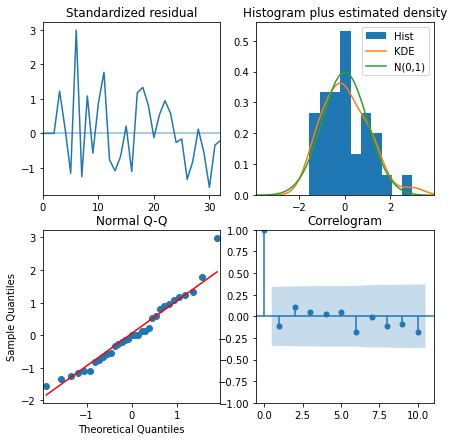

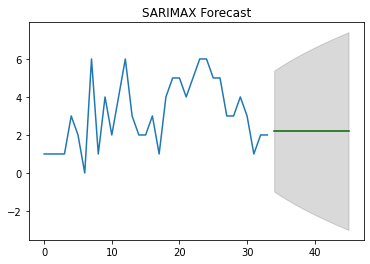

In [33]:
# 3. SARIMAX, seasonal arima with exogenous variables


# 3.0 Select random seq as an example
import random

random_seq_idx = random.randint(0,X_test.shape[0])
seq = X_test[random_seq_idx,:]


# 3.1 Decompose seq to get seasonal seq
from statsmodels.tsa.seasonal import seasonal_decompose

seq_decomposed = seasonal_decompose(seq,
                                model='additive',  # additive or multiplicative
                                period=12,
                                extrapolate_trend='freq')
seq_seasonal = seq_decomposed.seasonal
print('seasonal:', seq_seasonal)


# 3.2 Train SARIMAX Model
sxmodel = pm.auto_arima(seq,
                        exogenous=seq_seasonal,
                        start_p=1, start_q=1,
                        test='adf',
                        max_p=3, max_q=3, m=12,
                        start_P=0, seasonal=False,
                        # As a general rule, set the model parameters such that D never exceeds one. And the total differencing ‘d + D’ never exceeds 2. Try to keep only either SAR or SMA terms if your model has seasonal components.
                        d=1, D=1, trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)
sxmodel.summary()


# 3.3 Plot metrics: interpret the residual plots in ARIMA model
# Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.
# Top Right: The density plot suggest normal distribution with mean zero.
# Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.
# Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.
sxmodel.plot_diagnostics(figsize=(7,7))
plt.show()


# 3.4 Forecast
n_periods = 12
fitted, confint = sxmodel.predict(n_periods=n_periods,
                                    exogenous=seq_seasonal,
                                    return_conf_int=True)
index_of_fc = np.arange(len(seq), len(seq)+n_periods)


# 3.5 Plot the results
# make series for plotting purpose
fc_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

#plot
import matplotlib.pyplot as plt

plt.plot(seq)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title("SARIMAX Forecast")
plt.show()

In [ ]:
# submission_df = pd.DataFrame(pred, columns=['item_cnt_month'])
# submission_df.index.name = 'ID'
# submission_df

In [ ]:
# submission_df.to_csv('/kaggle/working/submission.csv')